# PDAC Calibration - 1y probability changes

Author: Sophie Wagner, sw3767@cumc.columbia.edu

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [68]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        for row_idx in range(layer.shape[0]):  # Loop over each row
            row = layer[row_idx]
            
            # Exclude diagonal (stay-in-state) and ACM (all-cause mortality) from scaling
            non_diag_sum = np.sum(row) - row[row_idx] 
            
            if non_diag_sum > 1:  # If the non-diag probabilities exceed 1
                scaling_factor = 1 / non_diag_sum
                row *= scaling_factor  # Scale 
            
            # Adjust diagonal (stay-in-state probability)
            row[row_idx] = max(0, 1 - non_diag_sum)
    
    return matrix.clip(0.0,1.0)

def create_matrix():
    
    matrix = np.zeros((len(c.age_layers), len(c.health_states_itos), len(c.health_states_itos)))
    age_50_idx = 6 if c.param_interval == 5 else 30
    matrix[:, 0, 1] = 1-(1-0.0011)**(1/25) # average risk after 50 ~ 0.0011, transformed to annual prob
    matrix[:age_50_idx, 0, 1] = np.linspace(0.000001,matrix[-1,0,1],age_50_idx)
    matrix[:, 1, 2] = c.model_inputs_dict['p_Local_to_Regional_PC']  
    matrix[:, 2, 3] = c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    
    matrix[:, 0, 1] = np.maximum(matrix[:,0,1], 0.0000001)
    matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    
    # Note: c.acm_rates configured for either 1y or 5y acm
    matrix[:, :7, 8] = c.acm_rates[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

## Markov model

In [61]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_5y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [69]:
def step(matrix, step_size, num_adj=3):
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.age_layers_5y, k=num_adj)
    # print(f"selected transitions: {step_tp}")
    # print(f"selected ages: {step_age}")
    small_matrix = matrix[2::5, :, :]
    # print(f"old matrix: {matrix}")
    # print(f"small_matrix: {new_matrix}")
    assert small_matrix.shape[0] == 13
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        old_param = small_matrix[age, from_state, to_state] 
        step_param = old_param * step_size
        small_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)
        # print(f"{from_state} -> {to_state} , age_layer {age}: old = {round(old_param,5)} ; new = {round(new_matrix[age, from_state, to_state],5)}")
    
    # print(f"new matrix after adj, pre constraints: {new_matrix}")
    small_matrix[-1, :, :] = np.minimum(small_matrix[-1, :, :], small_matrix[-2, :, :])
    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_matrix, axis=0, smooth=0.001)(c.ages_1y).clip(0.0,1.0)
    assert new_matrix.shape[0]==65
    
    # print(f"new matrix after smoothing: {new_matrix}")
    
    # # new_matrix = constrain_matrix(new_matrix)
    # # new_matrix = add_acm(new_matrix)
    # # new_matrix = add_csd(new_matrix)
    # # new_matrix = row_normalize(new_matrix)
    
    # print(f"new matrix after constraints: {new_matrix}")

    return new_matrix

In [70]:
def simulated_annealing(n_iterations, step_size, start_tmat, n_adj=5, starting_temp = 1, verbose=False, print_interval=1000):

    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)  # evaluate the initial point
    curr_t, curr_eval = best_t, best_eval  # current working solution
    ticker = 0

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        
        for i in range(n_iterations):

            # Run model
            candidate_t = np.copy(curr_t)
            candidate_t = step(candidate_t, step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)  # Evaluate candidate point

            # Update "best" if better than candidate
            if candidate_eval < best_eval:
                ticker = 0
                best_t, best_eval = np.copy(candidate_t), np.copy(candidate_eval)
                best_log = run_markov(best_t)

            else:
                ticker += 1

            t = starting_temp / (1 + 0.1 * np.log(i + 1))  # Slower cooling

            # Progress report
            if verbose and i>0 and i % print_interval == 0:
                log_adj, _, inc_log, _ = best_log
                total_dxd = np.sum(inc_log[4:7, :]) / c.N
                print(i, ": ", best_eval, "   PDAC: ", round(total_dxd, 5),"   tick:",ticker)
                if i % 50000 == 0:
                    transition_probs = p.extract_transition_probs(best_t, metric="avg")
                    print(f"Progress report, i = {i}")
                    print(transition_probs)
                    p.plot_vs_seer(log_adj, c.seer_inc)

            # Check if we should update "curr"
            diff = (candidate_eval - curr_eval)  # difference between candidate and current point evaluation
            metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
            if (diff < 0 or np.random.random() < metropolis):  # check if we should keep the new point
                curr_t, curr_eval = np.copy(candidate_t), np.copy(candidate_eval)  # store the new current point
                ticker = 0

            pbar.update(1)

    print(best_eval)
    
    return best_t

## Run 

In [64]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, starting_temp=1, print_interval=5000):
    start_tmat = None
    if tmat is not None:
        start_tmat = tmat
    else:
        start_tmat = create_matrix()
        print(start_tmat[0])
        
    initial_score = gof.objective(run_markov(start_tmat))
    print(f"Initial score: {round(initial_score, 5)}")
    print("Starting calibration...")
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=start_tmat, n_adj=n_adj, starting_temp=starting_temp, verbose=True, print_interval=print_interval)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    final_score = gof.objective(curr_log)
    log_adj, log_prev, log_inc, pop_log = curr_log
    tps = p.extract_transition_probs(curr_tmat, "markov", metric="avg", save=save_all, timestamp=timestamp)
    
    print("Done.")
    print("\nOUTPUTS:")
    
    # Saving
    if save_all:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        
    # else:
        # print(tps)
        # p.plot_vs_seer(log_adj, c.seer_inc, show_plot=True)
        # p.plot_vs_seer_total(log_adj, c.seer_inc, show_plot=True)
        # p.plot_params(curr_tmat,  show_plot=True)

    return curr_tmat

In [65]:
result=None
temps, step_sizes = [5,2,1,1,1], [0.2,0.2,0.2,0.15,0.15]
for epoch in range(5):
    print(f"EPOCH {(epoch+1)}/5 ----------------------------------------------------------")
    result = run_sa(tmat=result, save_all=True, n_iterations=200000, step_size=step_sizes[epoch], n_adj=7, starting_temp=temps[epoch])

EPOCH 1/5 ----------------------------------------------------------
[[ 0.999242000  0.000010000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000748000]
 [ 0.000000000  0.399252000  0.500000000  0.000000000  0.100000000  0.000000000  0.000000000  0.000000000  0.000748000]
 [ 0.000000000  0.000000000  0.119252000  0.500000000  0.000000000  0.380000000  0.000000000  0.000000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.479252000  0.000000000  0.000000000  0.520000000  0.000000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.789252000  0.000000000  0.000000000  0.210000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.659252000  0.000000000  0.340000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.499252000  0.500000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.00000000

Simulated annealing progress:   3%|▎         | 5063/200000 [00:13<08:36, 377.60iteration/s]

5000 :  1283.088176083722    PDAC:  0.00716    tick: 139


Simulated annealing progress:   5%|▌         | 10023/200000 [00:29<17:37, 179.67iteration/s]

10000 :  1192.7163806417395    PDAC:  0.00787    tick: 1527


Simulated annealing progress:   8%|▊         | 15026/200000 [00:47<14:38, 210.44iteration/s]

15000 :  1138.3723413301964    PDAC:  0.00843    tick: 583


Simulated annealing progress:  10%|█         | 20067/200000 [01:04<07:54, 378.98iteration/s]

20000 :  1047.3492385042475    PDAC:  0.00902    tick: 1214


Simulated annealing progress:  13%|█▎        | 25052/200000 [01:17<07:55, 367.99iteration/s]

25000 :  1035.0729305369618    PDAC:  0.00898    tick: 282


Simulated annealing progress:  15%|█▌        | 30052/200000 [01:31<07:24, 382.51iteration/s]

30000 :  1035.0729305369618    PDAC:  0.00898    tick: 5282


Simulated annealing progress:  18%|█▊        | 35056/200000 [01:45<07:22, 372.88iteration/s]

35000 :  1014.9819660354613    PDAC:  0.00943    tick: 704


Simulated annealing progress:  20%|██        | 40042/200000 [01:58<07:17, 365.43iteration/s]

40000 :  1004.534928222706    PDAC:  0.01035    tick: 3298


Simulated annealing progress:  23%|██▎       | 45042/200000 [02:12<06:50, 377.15iteration/s]

45000 :  998.0028858644636    PDAC:  0.00949    tick: 1008


Simulated annealing progress:  25%|██▌       | 50039/200000 [02:25<06:45, 369.90iteration/s]

50000 :  967.7480074503051    PDAC:  0.00942    tick: 391
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00006  0.00005  0.00005  0.00006  0.00006
1  u_PDAC_loc  u_PDAC_reg  0.82319  0.99713  0.64592  1.00000  0.93609
2  u_PDAC_reg  u_PDAC_dis  0.96400  0.87198  0.79130  1.00000  0.94500
3  u_PDAC_loc  d_PDAC_loc  0.09293  0.08547  0.08242  0.09306  0.09016
4  u_PDAC_reg  d_PDAC_reg  0.47395  0.35219  0.31819  0.49487  0.41703
5  u_PDAC_dis  d_PDAC_dis  0.50829  0.99512  0.35133  1.00000  0.76613


Simulated annealing progress:  28%|██▊       | 55042/200000 [02:39<06:29, 371.90iteration/s]

55000 :  962.1555698281195    PDAC:  0.00928    tick: 4319


Simulated annealing progress:  30%|███       | 60046/200000 [02:52<06:10, 378.14iteration/s]

60000 :  962.1555698281195    PDAC:  0.00928    tick: 322


Simulated annealing progress:  33%|███▎      | 65045/200000 [03:06<05:56, 378.37iteration/s]

65000 :  962.1555698281195    PDAC:  0.00928    tick: 5322


Simulated annealing progress:  35%|███▌      | 70076/200000 [03:20<05:45, 375.80iteration/s]

70000 :  962.1555698281195    PDAC:  0.00928    tick: 52


Simulated annealing progress:  38%|███▊      | 75061/200000 [03:33<05:41, 365.91iteration/s]

75000 :  962.1555698281195    PDAC:  0.00928    tick: 5052


Simulated annealing progress:  40%|████      | 80053/200000 [03:48<05:14, 381.29iteration/s]

80000 :  962.1555698281195    PDAC:  0.00928    tick: 2748


Simulated annealing progress:  43%|████▎     | 85056/200000 [04:02<05:02, 379.66iteration/s]

85000 :  962.1555698281195    PDAC:  0.00928    tick: 150


Simulated annealing progress:  45%|████▌     | 90045/200000 [04:16<04:51, 376.64iteration/s]

90000 :  952.8458302990651    PDAC:  0.00882    tick: 4655


Simulated annealing progress:  48%|████▊     | 95050/200000 [04:29<04:41, 373.36iteration/s]

95000 :  926.909834450287    PDAC:  0.00895    tick: 595


Simulated annealing progress:  50%|█████     | 100078/200000 [04:44<04:31, 368.57iteration/s]

100000 :  924.5747175747551    PDAC:  0.00944    tick: 4435
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00006  0.00006  0.00005  0.00007  0.00006
1  u_PDAC_loc  u_PDAC_reg  0.79327  0.98154  0.58575  1.00000  0.92020
2  u_PDAC_reg  u_PDAC_dis  0.96107  0.93689  0.90327  0.99240  0.96312
3  u_PDAC_loc  d_PDAC_loc  0.09388  0.09073  0.08931  0.09400  0.09273
4  u_PDAC_reg  d_PDAC_reg  0.51057  0.37232  0.31893  0.52026  0.45113
5  u_PDAC_dis  d_PDAC_dis  0.52631  0.93998  0.38520  0.96941  0.74702


Simulated annealing progress:  53%|█████▎    | 105020/200000 [04:58<09:26, 167.56iteration/s]

105000 :  924.5747175747551    PDAC:  0.00944    tick: 9435


Simulated annealing progress:  55%|█████▌    | 110074/200000 [05:12<03:56, 379.71iteration/s]

110000 :  919.4067072466282    PDAC:  0.00906    tick: 3474


Simulated annealing progress:  58%|█████▊    | 115042/200000 [05:25<03:46, 374.37iteration/s]

115000 :  919.4067072466282    PDAC:  0.00906    tick: 8474


Simulated annealing progress:  60%|██████    | 120057/200000 [05:39<03:30, 380.44iteration/s]

120000 :  919.4067072466282    PDAC:  0.00906    tick: 13474


Simulated annealing progress:  63%|██████▎   | 125054/200000 [05:52<03:16, 382.08iteration/s]

125000 :  919.4067072466282    PDAC:  0.00906    tick: 18474


Simulated annealing progress:  65%|██████▌   | 130064/200000 [06:07<03:41, 315.28iteration/s]

130000 :  919.4067072466282    PDAC:  0.00906    tick: 1161


Simulated annealing progress:  68%|██████▊   | 135068/200000 [06:20<02:47, 386.94iteration/s]

135000 :  919.4067072466282    PDAC:  0.00906    tick: 6161


Simulated annealing progress:  70%|███████   | 140081/200000 [06:34<02:36, 382.88iteration/s]

140000 :  919.4067072466282    PDAC:  0.00906    tick: 11161


Simulated annealing progress:  73%|███████▎  | 145041/200000 [06:47<02:20, 391.24iteration/s]

145000 :  919.4067072466282    PDAC:  0.00906    tick: 16161


Simulated annealing progress:  75%|███████▌  | 150053/200000 [07:00<02:20, 355.36iteration/s]

150000 :  919.4067072466282    PDAC:  0.00906    tick: 21161
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00006  0.00006  0.00005  0.00007  0.00006
1  u_PDAC_loc  u_PDAC_reg  0.81607  0.98521  0.64522  1.00000  0.92855
2  u_PDAC_reg  u_PDAC_dis  0.91788  0.94064  0.81762  0.99537  0.94889
3  u_PDAC_loc  d_PDAC_loc  0.09392  0.09086  0.08953  0.09396  0.09276
4  u_PDAC_reg  d_PDAC_reg  0.51198  0.37480  0.32874  0.52446  0.45269
5  u_PDAC_dis  d_PDAC_dis  0.52029  0.92164  0.38728  0.94353  0.73726


Simulated annealing progress:  78%|███████▊  | 155055/200000 [07:14<02:02, 365.45iteration/s]

155000 :  919.4067072466282    PDAC:  0.00906    tick: 26161


Simulated annealing progress:  80%|████████  | 160064/200000 [07:27<01:45, 377.89iteration/s]

160000 :  919.4067072466282    PDAC:  0.00906    tick: 31161


Simulated annealing progress:  83%|████████▎ | 165064/200000 [07:40<01:31, 381.58iteration/s]

165000 :  919.4067072466282    PDAC:  0.00906    tick: 36161


Simulated annealing progress:  85%|████████▌ | 170062/200000 [07:54<01:16, 390.72iteration/s]

170000 :  919.4067072466282    PDAC:  0.00906    tick: 41161


Simulated annealing progress:  88%|████████▊ | 175060/200000 [08:07<01:04, 385.02iteration/s]

175000 :  919.4067072466282    PDAC:  0.00906    tick: 526


Simulated annealing progress:  90%|█████████ | 180054/200000 [08:20<00:52, 382.31iteration/s]

180000 :  918.8629625753092    PDAC:  0.00988    tick: 4985


Simulated annealing progress:  93%|█████████▎| 185066/200000 [08:34<00:40, 370.12iteration/s]

185000 :  918.8629625753092    PDAC:  0.00988    tick: 9985


Simulated annealing progress:  95%|█████████▌| 190050/200000 [08:47<00:25, 383.61iteration/s]

190000 :  918.8629625753092    PDAC:  0.00988    tick: 14985


Simulated annealing progress:  98%|█████████▊| 195067/200000 [09:01<00:12, 381.80iteration/s]

195000 :  918.8629625753092    PDAC:  0.00988    tick: 19985


Simulated annealing progress: 100%|██████████| 200000/200000 [09:16<00:00, 359.28iteration/s]


918.8629625753092
Done.

OUTPUTS:
EPOCH 2/5 ----------------------------------------------------------
Initial score: 918.86296
Starting calibration...


Simulated annealing progress:   3%|▎         | 5064/200000 [00:13<08:45, 370.80iteration/s]

5000 :  918.8629625753092    PDAC:  0.00988    tick: 5001


Simulated annealing progress:   5%|▌         | 10050/200000 [00:27<08:17, 381.65iteration/s]

10000 :  918.8629625753092    PDAC:  0.00988    tick: 10001


Simulated annealing progress:   8%|▊         | 15070/200000 [00:43<08:50, 348.41iteration/s]

15000 :  918.6271054274807    PDAC:  0.00907    tick: 4050


Simulated annealing progress:  10%|█         | 20038/200000 [01:00<08:15, 363.43iteration/s]

20000 :  907.776347860169    PDAC:  0.00975    tick: 1548


Simulated annealing progress:  13%|█▎        | 25068/200000 [01:15<07:35, 384.34iteration/s]

25000 :  901.856505475618    PDAC:  0.00977    tick: 3873


Simulated annealing progress:  15%|█▌        | 30057/200000 [01:30<07:35, 372.92iteration/s]

30000 :  901.856505475618    PDAC:  0.00977    tick: 8873


Simulated annealing progress:  18%|█▊        | 35064/200000 [01:44<07:03, 389.63iteration/s]

35000 :  901.856505475618    PDAC:  0.00977    tick: 13873


Simulated annealing progress:  20%|██        | 40049/200000 [01:57<06:58, 382.18iteration/s]

40000 :  901.856505475618    PDAC:  0.00977    tick: 18873


Simulated annealing progress:  23%|██▎       | 45056/200000 [02:11<06:51, 376.83iteration/s]

45000 :  901.856505475618    PDAC:  0.00977    tick: 23873


Simulated annealing progress:  25%|██▌       | 50036/200000 [02:24<06:49, 366.55iteration/s]

50000 :  901.856505475618    PDAC:  0.00977    tick: 28873
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00006  0.00006  0.00005  0.00007  0.00007
1  u_PDAC_loc  u_PDAC_reg  0.74286  1.00000  0.54461  1.00000  0.91003
2  u_PDAC_reg  u_PDAC_dis  0.99150  0.95531  0.93730  0.99939  0.98055
3  u_PDAC_loc  d_PDAC_loc  0.09756  0.09058  0.08990  0.09801  0.09414
4  u_PDAC_reg  d_PDAC_reg  0.54408  0.39223  0.35737  0.56973  0.47249
5  u_PDAC_dis  d_PDAC_dis  0.51260  0.82021  0.40659  0.84852  0.67992


Simulated annealing progress:  28%|██▊       | 55076/200000 [02:38<06:37, 364.21iteration/s]

55000 :  901.856505475618    PDAC:  0.00977    tick: 33873


Simulated annealing progress:  30%|███       | 60043/200000 [02:52<06:24, 363.81iteration/s]

60000 :  890.6161665524976    PDAC:  0.01001    tick: 542


Simulated annealing progress:  33%|███▎      | 65040/200000 [03:06<06:03, 371.04iteration/s]

65000 :  851.2739673305177    PDAC:  0.00928    tick: 988


Simulated annealing progress:  35%|███▌      | 70035/200000 [03:19<05:47, 374.06iteration/s]

70000 :  838.962713746376    PDAC:  0.01035    tick: 549


Simulated annealing progress:  38%|███▊      | 75028/200000 [03:33<05:35, 373.03iteration/s]

75000 :  818.7505279307761    PDAC:  0.01039    tick: 246


Simulated annealing progress:  40%|████      | 80082/200000 [03:48<05:12, 383.80iteration/s]

80000 :  809.4361465647883    PDAC:  0.01021    tick: 2993


Simulated annealing progress:  43%|████▎     | 85073/200000 [04:02<05:03, 379.08iteration/s]

85000 :  809.4361465647883    PDAC:  0.01021    tick: 7993


Simulated annealing progress:  45%|████▌     | 90036/200000 [04:15<05:04, 360.73iteration/s]

90000 :  809.4361465647883    PDAC:  0.01021    tick: 12993


Simulated annealing progress:  48%|████▊     | 95063/200000 [04:29<04:36, 379.49iteration/s]

95000 :  809.4361465647883    PDAC:  0.01021    tick: 17993


Simulated annealing progress:  50%|█████     | 100052/200000 [04:43<04:30, 369.94iteration/s]

100000 :  782.6850928819284    PDAC:  0.00991    tick: 557
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00008  0.00008  0.00005  0.00010  0.00008
1  u_PDAC_loc  u_PDAC_reg  0.61353  0.94060  0.38624  0.98122  0.82817
2  u_PDAC_reg  u_PDAC_dis  0.99457  0.99504  0.98936  1.00000  0.99650
3  u_PDAC_loc  d_PDAC_loc  0.10523  0.09206  0.09010  0.10877  0.09842
4  u_PDAC_reg  d_PDAC_reg  0.60043  0.41232  0.36824  0.64177  0.51002
5  u_PDAC_dis  d_PDAC_dis  0.51532  0.77551  0.42226  0.79713  0.65593


Simulated annealing progress:  53%|█████▎    | 105054/200000 [04:58<04:19, 366.04iteration/s]

105000 :  773.8812777653936    PDAC:  0.00993    tick: 1351


Simulated annealing progress:  55%|█████▌    | 110065/200000 [05:11<03:55, 382.45iteration/s]

110000 :  773.8812777653936    PDAC:  0.00993    tick: 6351


Simulated annealing progress:  58%|█████▊    | 115051/200000 [05:25<03:47, 372.64iteration/s]

115000 :  729.9899605427413    PDAC:  0.00983    tick: 868


Simulated annealing progress:  60%|██████    | 120058/200000 [05:38<03:34, 373.19iteration/s]

120000 :  716.1992746472663    PDAC:  0.01014    tick: 1681


Simulated annealing progress:  63%|██████▎   | 125062/200000 [05:52<03:14, 384.59iteration/s]

125000 :  716.1992746472663    PDAC:  0.01014    tick: 6681


Simulated annealing progress:  65%|██████▌   | 130060/200000 [06:06<03:00, 387.46iteration/s]

130000 :  716.1992746472663    PDAC:  0.01014    tick: 3390


Simulated annealing progress:  68%|██████▊   | 135054/200000 [06:20<02:51, 377.82iteration/s]

135000 :  716.1992746472663    PDAC:  0.01014    tick: 3463


Simulated annealing progress:  70%|███████   | 140060/200000 [06:34<02:39, 374.72iteration/s]

140000 :  711.65369907567    PDAC:  0.01006    tick: 4689


Simulated annealing progress:  73%|███████▎  | 145067/200000 [06:47<02:28, 371.12iteration/s]

145000 :  711.65369907567    PDAC:  0.01006    tick: 9689


Simulated annealing progress:  75%|███████▌  | 150047/200000 [07:01<02:13, 374.08iteration/s]

150000 :  711.65369907567    PDAC:  0.01006    tick: 14689
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00009  0.00009  0.00006  0.00011  0.00010
1  u_PDAC_loc  u_PDAC_reg  0.57978  0.93788  0.32408  0.96769  0.81316
2  u_PDAC_reg  u_PDAC_dis  0.99789  0.99850  0.99508  1.00000  0.99876
3  u_PDAC_loc  d_PDAC_loc  0.10620  0.09864  0.09600  0.10792  0.10113
4  u_PDAC_reg  d_PDAC_reg  0.57130  0.46012  0.42848  0.58590  0.52128
5  u_PDAC_dis  d_PDAC_dis  0.50176  0.74256  0.40451  0.74924  0.63703


Simulated annealing progress:  78%|███████▊  | 155044/200000 [07:14<01:57, 383.18iteration/s]

155000 :  711.65369907567    PDAC:  0.01006    tick: 19689


Simulated annealing progress:  80%|████████  | 160049/200000 [07:28<01:44, 383.24iteration/s]

160000 :  711.65369907567    PDAC:  0.01006    tick: 4383


Simulated annealing progress:  83%|████████▎ | 165077/200000 [07:41<01:32, 377.55iteration/s]

165000 :  711.65369907567    PDAC:  0.01006    tick: 9383


Simulated annealing progress:  85%|████████▌ | 170054/200000 [07:55<01:18, 383.33iteration/s]

170000 :  711.65369907567    PDAC:  0.01006    tick: 14383


Simulated annealing progress:  88%|████████▊ | 175058/200000 [08:08<01:03, 393.21iteration/s]

175000 :  711.65369907567    PDAC:  0.01006    tick: 19383


Simulated annealing progress:  90%|█████████ | 180062/200000 [08:22<00:50, 391.31iteration/s]

180000 :  711.65369907567    PDAC:  0.01006    tick: 24383


Simulated annealing progress:  93%|█████████▎| 185015/200000 [08:36<01:18, 190.26iteration/s]

185000 :  711.65369907567    PDAC:  0.01006    tick: 29383


Simulated annealing progress:  95%|█████████▌| 190014/200000 [09:07<01:07, 148.17iteration/s]

190000 :  711.65369907567    PDAC:  0.01006    tick: 34383


Simulated annealing progress:  98%|█████████▊| 195019/200000 [09:35<00:25, 192.83iteration/s]

195000 :  711.65369907567    PDAC:  0.01006    tick: 39383


Simulated annealing progress: 100%|██████████| 200000/200000 [10:08<00:00, 328.61iteration/s]


711.65369907567
Done.

OUTPUTS:
EPOCH 3/5 ----------------------------------------------------------
Initial score: 711.6537
Starting calibration...


Simulated annealing progress:   3%|▎         | 5030/200000 [00:26<21:10, 153.45iteration/s]

5000 :  711.65369907567    PDAC:  0.01006    tick: 5001


Simulated annealing progress:   5%|▌         | 10035/200000 [00:51<09:50, 321.60iteration/s]

10000 :  711.65369907567    PDAC:  0.01006    tick: 10001


Simulated annealing progress:   8%|▊         | 15008/200000 [01:17<47:53, 64.38iteration/s] 

15000 :  700.2228805724876    PDAC:  0.01029    tick: 2739


Simulated annealing progress:  10%|█         | 20020/200000 [02:05<26:08, 114.78iteration/s] 

20000 :  700.2228805724876    PDAC:  0.01029    tick: 7739


Simulated annealing progress:  13%|█▎        | 25026/200000 [02:46<21:25, 136.08iteration/s]

25000 :  700.2228805724876    PDAC:  0.01029    tick: 12739


Simulated annealing progress:  15%|█▌        | 30020/200000 [03:21<27:04, 104.60iteration/s]

30000 :  700.2228805724876    PDAC:  0.01029    tick: 17739


Simulated annealing progress:  18%|█▊        | 35014/200000 [03:52<19:53, 138.19iteration/s]

35000 :  700.2228805724876    PDAC:  0.01029    tick: 22739


Simulated annealing progress:  20%|██        | 40019/200000 [04:19<20:25, 130.52iteration/s]

40000 :  700.2228805724876    PDAC:  0.01029    tick: 27739


Simulated annealing progress:  23%|██▎       | 45072/200000 [04:55<11:12, 230.53iteration/s]

45000 :  700.2228805724876    PDAC:  0.01029    tick: 32739


Simulated annealing progress:  25%|██▌       | 50054/200000 [05:28<09:09, 272.68iteration/s]

50000 :  700.2228805724876    PDAC:  0.01029    tick: 37739
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00008  0.00009  0.00007  0.00011  0.00009
1  u_PDAC_loc  u_PDAC_reg  0.60623  0.94518  0.31823  0.96992  0.82814
2  u_PDAC_reg  u_PDAC_dis  0.99772  0.99847  0.99568  1.00000  0.99873
3  u_PDAC_loc  d_PDAC_loc  0.10601  0.09787  0.09712  0.10877  0.10102
4  u_PDAC_reg  d_PDAC_reg  0.57509  0.46228  0.43206  0.58992  0.52337
5  u_PDAC_dis  d_PDAC_dis  0.48748  0.74332  0.37676  0.75518  0.63033


Simulated annealing progress:  28%|██▊       | 55013/200000 [05:57<16:43, 144.46iteration/s]

55000 :  700.2228805724876    PDAC:  0.01029    tick: 42739


Simulated annealing progress:  30%|███       | 60054/200000 [06:23<07:16, 320.40iteration/s]

60000 :  700.2228805724876    PDAC:  0.01029    tick: 47739


Simulated annealing progress:  33%|███▎      | 65019/200000 [06:54<16:28, 136.58iteration/s]

65000 :  700.2228805724876    PDAC:  0.01029    tick: 52739


Simulated annealing progress:  35%|███▌      | 70021/200000 [07:23<15:30, 139.68iteration/s]

70000 :  700.2228805724876    PDAC:  0.01029    tick: 57739


Simulated annealing progress:  38%|███▊      | 75043/200000 [07:53<06:17, 330.61iteration/s]

75000 :  700.2228805724876    PDAC:  0.01029    tick: 62739


Simulated annealing progress:  40%|████      | 80064/200000 [08:17<06:44, 296.37iteration/s]

80000 :  700.2228805724876    PDAC:  0.01029    tick: 67739


Simulated annealing progress:  43%|████▎     | 85032/200000 [08:50<14:52, 128.82iteration/s]

85000 :  700.2228805724876    PDAC:  0.01029    tick: 72739


Simulated annealing progress:  45%|████▌     | 90027/200000 [09:29<12:18, 148.93iteration/s]

90000 :  700.2228805724876    PDAC:  0.01029    tick: 77739


Simulated annealing progress:  48%|████▊     | 95017/200000 [10:04<14:05, 124.15iteration/s]

95000 :  700.2228805724876    PDAC:  0.01029    tick: 82739


Simulated annealing progress:  50%|█████     | 100061/200000 [10:38<04:54, 339.05iteration/s]

100000 :  700.2228805724876    PDAC:  0.01029    tick: 87739
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00008  0.00009  0.00007  0.00011  0.00009
1  u_PDAC_loc  u_PDAC_reg  0.60623  0.94518  0.31823  0.96992  0.82814
2  u_PDAC_reg  u_PDAC_dis  0.99772  0.99847  0.99568  1.00000  0.99873
3  u_PDAC_loc  d_PDAC_loc  0.10601  0.09787  0.09712  0.10877  0.10102
4  u_PDAC_reg  d_PDAC_reg  0.57509  0.46228  0.43206  0.58992  0.52337
5  u_PDAC_dis  d_PDAC_dis  0.48748  0.74332  0.37676  0.75518  0.63033


Simulated annealing progress:  53%|█████▎    | 105020/200000 [10:59<10:29, 150.94iteration/s]

105000 :  700.2228805724876    PDAC:  0.01029    tick: 92739


Simulated annealing progress:  55%|█████▌    | 110015/200000 [11:35<10:21, 144.68iteration/s]

110000 :  700.2228805724876    PDAC:  0.01029    tick: 97739


Simulated annealing progress:  58%|█████▊    | 115019/200000 [12:05<09:38, 146.78iteration/s]

115000 :  700.2228805724876    PDAC:  0.01029    tick: 102739


Simulated annealing progress:  60%|██████    | 120020/200000 [12:21<05:11, 256.93iteration/s]

120000 :  700.2228805724876    PDAC:  0.01029    tick: 107739


Simulated annealing progress:  63%|██████▎   | 125046/200000 [12:36<03:12, 389.07iteration/s]

125000 :  696.7175250848718    PDAC:  0.01044    tick: 2580


Simulated annealing progress:  65%|██████▌   | 130066/200000 [12:49<03:00, 387.92iteration/s]

130000 :  696.7175250848718    PDAC:  0.01044    tick: 7580


Simulated annealing progress:  68%|██████▊   | 135059/200000 [13:04<02:42, 398.81iteration/s]

135000 :  696.7175250848718    PDAC:  0.01044    tick: 12580


Simulated annealing progress:  70%|███████   | 140068/200000 [13:17<02:36, 381.88iteration/s]

140000 :  696.7175250848718    PDAC:  0.01044    tick: 17580


Simulated annealing progress:  71%|███████▏  | 142821/200000 [13:27<05:23, 176.96iteration/s]


KeyboardInterrupt: 

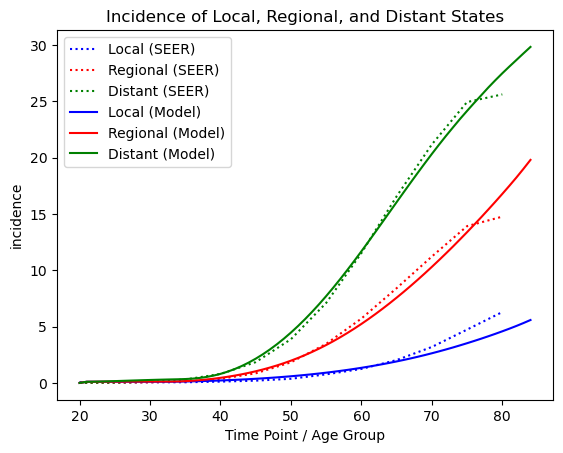

In [140]:
# result_next.shape
# small_tmat = result_next[::5,:,:]
# tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_tmat, axis=0, smooth=0.001)(c.ages_1y)
# tmat_smoothed = add_acm(tmat_smoothed)
# tmat_smoothed = add_csd(tmat_smoothed)
# tmat_smoothed = constrain_matrix(tmat_smoothed)
# tmat_smoothed = row_normalize(tmat_smoothed)
# result_next_next = run_sa(tmat_smoothed)
# temp = result_next_next.copy()
# temp[:30, 0, 1] = np.maximum(temp[:30, 0, 1], 0.000001)
# temp[30:50,0,1]*=1.3
# temp[50:, 0, 1] = 1.5*temp[50,0,1]
# temp[:20,1,2]*=0.9
# temp[:20,2,3]*=0.9
# temp[30:,1,2]=min(result_next_next[:,1,2])
# temp[30:,2,3]=min(result_next_next[:,2,3])
# temp[50:,1,2]=min(result_next_next[:,1,2])*0.8
# temp[50:,2,3]=min(result_next_next[:,2,3])*0.8
# temp[50:,1,4]*=1.2
# temp = temp[::5,:,:]
# tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
# tmat_smoothed = add_acm(tmat_smoothed)
# tmat_smoothed = add_csd(tmat_smoothed)
# tmat_smoothed = constrain_matrix(tmat_smoothed)
# tmat_smoothed = row_normalize(tmat_smoothed)
# log = run_markov(tmat_smoothed)
# p.plot_vs_seer(log[0], c.seer_inc)

### Post-processing

In [28]:
import os
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

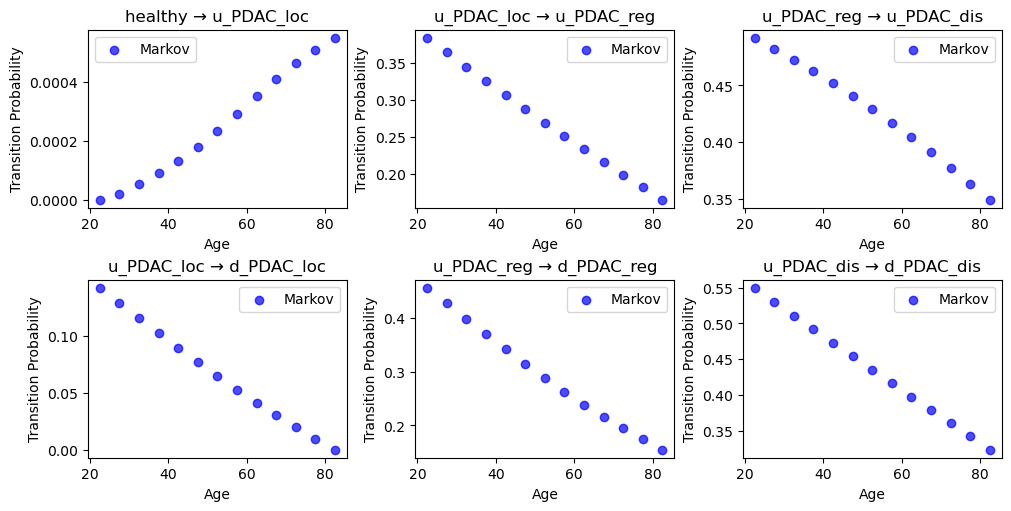

In [31]:
p.plot_params(result, show_plot=True)

In [29]:
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=False, timestamp="20241218_1605")
p.plot_params(markov_tmat, treeage_tmat, save_imgs=False, show_plot=True)

ValueError: 'ydata' data must be a 1-D or N-D array with shape[0] that is equal to 'xdata' size (10)